In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import sys
sys.path.append("..")
import data_loader

In [6]:
def format_oxidation(row, column, to_replace):
    peptide = row[column]
#     print(to_replace)
    replace_with = "+15.995"
    if pd.isna(peptide):
        new_pep = peptide
    else:
        if to_replace in peptide:
            new_pep = peptide.replace(to_replace, replace_with)
        else:
            new_pep = peptide
    return new_pep

def format_carbamidomethyl(row, column, to_replace):
    peptide = row[column]
#     print(to_replace)
    replace_with = ""
    if pd.isna(peptide):
        new_pep = peptide
    else:
        if to_replace in peptide:
            new_pep = peptide.replace(to_replace, replace_with)
        else:
            new_pep = peptide
    return new_pep


In [7]:
def clean_MM(input_file):
    data = pd.read_csv(input_file, sep = '\t')

    #make a new col that includes modifide peptides
    data['temp_peptide'] = data.apply(lambda row: format_oxidation(row, "Full Sequence", "[Common Variable:Oxidation on M]"), axis=1)
    data["temp2"] = data.apply(lambda row: format_carbamidomethyl(row, "temp_peptide", "[Common Fixed:Carbamidomethyl on C]"), axis=1)

    data = data.replace({"Decoy": {'Y': True, 'N': False}})
    #uniform naming
    data_new = data.rename({"Decoy": "decoy", "Scan Number": "scan", "temp2": "peptide", 'PEP_QValue': 'probability'}, axis=1)
    data_new = data_new.filter((['decoy', 'scan', 'peptide','probability', 
                                 "Matched Ion Series", 'Matched Ion Intensities', 'Matched Ion Counts', 'Matched Ion Mass Diff (Ppm)']))

    return data_new


In [8]:
def filter_data(df, SC):
    df = df[df["decoy"]==False]
    df = df.sort_values("probability")
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    df = df.sort_values("probability")
    df = df.drop_duplicates(subset=["peptide"], keep="first")#I only want unique peptides 
    if SC==True: 
        df = df[(df["probability"] <= .1) & (df["probability"] > .01)]
    else:
        df = df[df["probability"] <= .01]
    return df


In [5]:
small = clean_MM("~/Payne/bulk_data_vs_2ng/Ex_Auto_DrM3_30umT4_2ngQC_60m_half_PSMs.psmtsv.gz")
large = clean_MM("~/Payne/bulk_data_vs_2ng/metamorpheus_output/AllPSMs2.psmtsv")

small = filter_data(small, SC=True)
large = filter_data(large, SC=False)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (11,19,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
small.tail()

,decoy,scan,peptide,probability,Matched Ion Series,Matched Ion Intensities,Matched Ion Counts,Matched Ion Mass Diff (Ppm)
23305,False,16600,QEIFELCIK,0.098739,"[b1+1, b2+1, b3+1];[y1+1, y2+1]","[b1+1:7668, b2+1:5556, b3+1:1848];[y1+1:5975, ...",5,"[b1+1:3.36, b2+1:2.90, b3+1:1.80];[y1+1:4.73, ..."
19253,False,33360,GFGFVTFADPASVDK,0.099120,"[b2+1, b3+1];[y6+1, y9+1, y10+1]","[b2+1:755, b3+1:1272];[y6+1:2993, y9+1:1113, y...",5,"[b2+1:4.11, b3+1:4.46];[y6+1:3.59, y9+1:-1.17,..."
19996,False,11542,KPAPPPAPPQATK,0.099349,"[b1+1, b2+1, b4+1];[y5+1, y6+1]","[b1+1:1754, b2+1:670, b4+1:1946];[y5+1:837, y6...",5,"[b1+1:3.17, b2+1:4.11, b4+1:4.95];[y5+1:2.18, ..."
19207,False,22905,VIVGALLR,0.099387,"[b2+1, b3+1];[y1+1, y5+1, y6+1]","[b2+1:17206, b3+1:1990];[y1+1:6105, y5+1:15344...",5,"[b2+1:4.80, b3+1:5.04];[y1+1:3.10, y5+1:0.72, ..."
19286,False,34105,TLTDELAALQITGVK,0.099806,"[b2+1];[y4+1, y8+1, y9+1, y10+1]","[b2+1:1720];[y4+1:850, y8+1:1893, y9+1:2452, y...",5,"[b2+1:0.87];[y4+1:5.62, y8+1:1.45, y9+1:1.60, ..."


In [7]:
#how many match?
pep_in_both = list(set(small["peptide"]).intersection(set(large["peptide"])))
len(pep_in_both)

149

In [8]:
small = small.loc[small['peptide'].isin(pep_in_both)]
large = large.loc[large['peptide'].isin(pep_in_both)]

In [9]:
def count_Y(row):
    count = row['Matched Ion Series'].count("y")
    return(count)

def count_B(row):
    count = row['Matched Ion Series'].count("b")
    return(count)

In [10]:
#count y and b peaks
small["b_peaks"] = small.apply(count_B, axis=1)
small["y_peaks"] = small.apply(count_Y, axis=1)
small["y_peaks"] = small.apply(count_Y, axis=1)

#count y and b peaks
large["b_peaks"] = large.apply(count_B, axis=1)
large["y_peaks"] = large.apply(count_Y, axis=1)


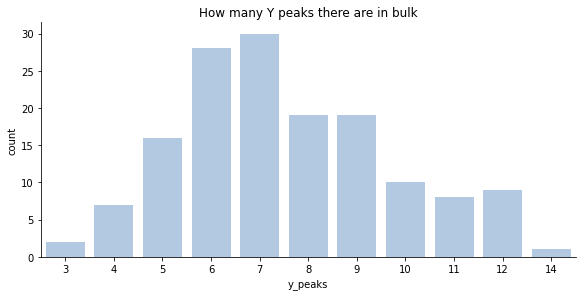

In [91]:
#How many y and b peaks are there on average?
plot = sns.catplot(x="y_peaks", color= '#abc9ea', hue=None,
                data=large, kind="count",
                height=4, aspect=2).set(title='How many Y peaks there are in bulk')

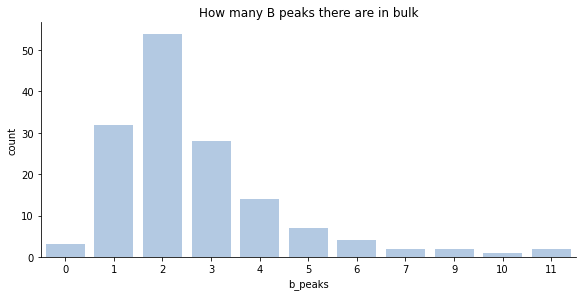

In [92]:
plot = sns.catplot(x="b_peaks", color= '#abc9ea', hue=None,
                data=large, kind="count",
                height=4, aspect=2).set(title='How many B peaks there are in bulk')

In [50]:
#for each protein count number of peaks for bulk and single cell, and get the difference

#give them the same index (index by peptide name)
new_small = small.set_index("peptide")
new_large = large.set_index("peptide")
both = pd.merge(left=new_small, right=new_large,suffixes=('_small', '_large'), left_index=True, right_index=True, how="outer")
# # small["Matched Ion Counts"]- large["Matched Ion Counts"]
both["diff_total"] = both["Matched Ion Counts_large"] - both["Matched Ion Counts_small"] 
both["diff_y"] = both["y_peaks_large"] - both["y_peaks_small"]
both["diff_b"] = both["b_peaks_large"] - both["b_peaks_small"]
####
#0 mean that they have the same number of peaks
# positive means that sc spectrum had more peaks
# negative means that bulk had more peaks

In [51]:
len(both)

149

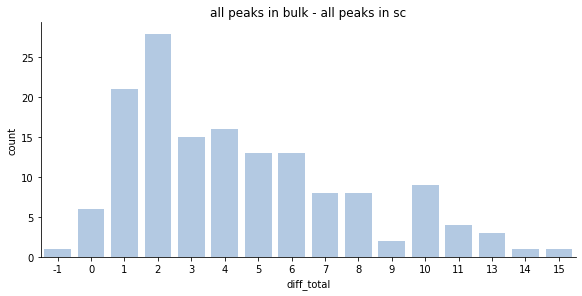

In [52]:
plot = sns.catplot(x="diff_total", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title='all peaks in bulk - all peaks in sc')

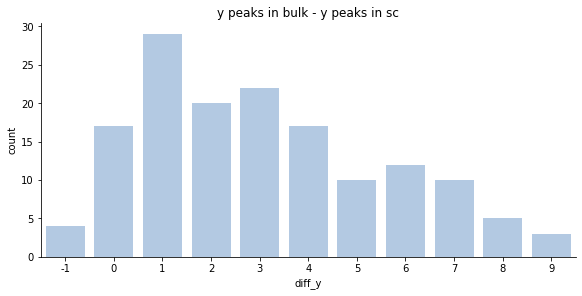

In [53]:
plot = sns.catplot(x="diff_y", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="y peaks in bulk - y peaks in sc")

In [97]:
(len(both[both['diff_y']>=3]) *100)/len(both)

53.02013422818792

In [98]:
(len(both[both['diff_b']>=3]) *100)/len(both)

18.79194630872483

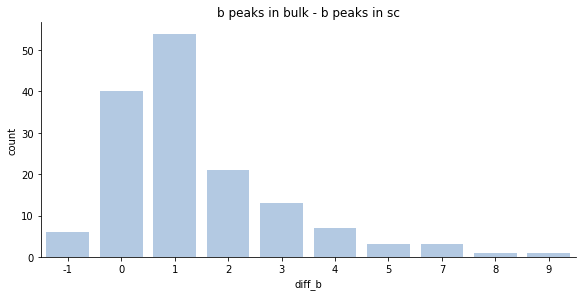

In [54]:
plot = sns.catplot(x="diff_b", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="b peaks in bulk - b peaks in sc")

In [83]:
# get exmaple spectra
missing_1y = both[both['diff_y']==1]
missing_1y[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
AISSSAISR,13974,19331
AMGIMNSFLNDIFER,39156,90361
DAAFQNVLTHVCLD,33813,85875
DIMLATGK,19663,42674
ECFYQPMPLK,24934,58444
ELQEQMSR,13718,19072
ESYPVFYLFR,39231,87696
EVPGPDCR,12677,17753
EVQMGDFVR,23510,51163


In [84]:
missing_4y = both[both['diff_y']==4]
missing_4y[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
AIAYLFPSGLFEK,38715,88390
FLAVGLVDNTVR,28557,69777
FVFSLVDAMNGK,35064,82453
GFAFVYFENVDDAK,34781,82297
GPVKPTGGPGGGGTQTQQQMNQLK,15559,26466
HPQPGAVELAAK,14701,22689
IQSTVTQPGGK,12286,17253
KPGGFDISLFYR,30548,68351
LDRETEELHHDR,10887,8262


In [55]:
import numbers
def get_intensities(row, small):
    intensities = []
    if small == True:
        line = row["Matched Ion Intensities_small"].split(";")
    else:
        line = row["Matched Ion Intensities_large"].split(";")
    for el in line:
        el = el.strip('][').split(",")
        for sub_el in el:
            sub_el = sub_el.split(":")[1]
            intensities.append(sub_el)
    return intensities

both["intensity_small"] = both.apply(lambda row: get_intensities(row, small=True), axis=1)
both["intensity_large"] = both.apply(lambda row: get_intensities(row, small=False), axis=1)

In [56]:
#get top 3 intensities
def get_top3(row, size, top):
    row['intensity_'+size].sort(key=int, reverse=True)
    if top==True:
        return3 = row['intensity_'+size][:3]
        return3 = [float(i) for i in return3]
    else:
        return3 = row['intensity_'+size][-3:]
        return3 = [float(i) for i in return3]
        
    return return3


both["top3_small"] = both.apply(lambda row: get_top3(row, size="small", top=True), axis=1)
both["bottom3_small"] = both.apply(lambda row: get_top3(row, size='small', top=False), axis=1)
both["top3_large"] = both.apply(lambda row: get_top3(row, size="large", top=True), axis=1)
both["bottom3_large"] = both.apply(lambda row: get_top3(row, size='large', top=False), axis=1)


In [57]:
def get_intensity_diff(row, size):
    intensity_diff = st.mean(row["top3_"+size])/st.mean(row["bottom3_"+size])
    return intensity_diff

both['intensity_diff_small'] = both.apply(lambda row: get_intensity_diff(row, size="small"), axis=1)
both['intensity_diff_large'] = both.apply(lambda row: get_intensity_diff(row, size="large"), axis=1)


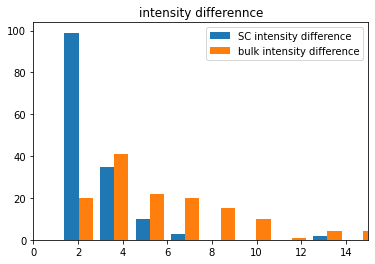

In [58]:
x = both["intensity_diff_small"]
y = both["intensity_diff_large"]
plt.hist([x, y], bins = 20)
plt.legend(['SC intensity difference', 'bulk intensity difference'])
plt.title("intensity differennce")
plt.xlim([0,15])
plt.show()

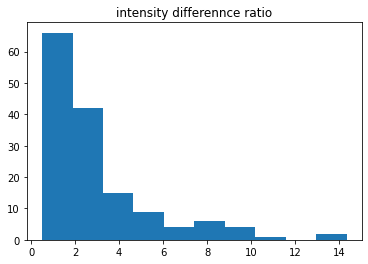

In [59]:
both["intensity_diff_ratio"] = both["intensity_diff_large"]/both["intensity_diff_small"]


plt.hist([both["intensity_diff_ratio"]])
plt.title("intensity differennce ratio")
plt.show()

In [60]:
both['intensity_diff_ratio']

peptide
AAAGAVGLER              0.739560
AEFGPPGPGAGSR           2.544400
AELNPWPEYIYTR           8.524909
AGFAGDQIPK              5.606697
AIAYLFPSGLFEK           2.942312
                         ...    
YFTLGLPTGSTPLGCYK       1.139329
YGDGGSSFQSTTGHCVHMR     1.062347
YLGLLENLR               1.267557
YNGEPEHIER              0.904361
YSNFVSFPLYLNGR         11.145661
Name: intensity_diff_ratio, Length: 149, dtype: float64

In [62]:
#example of 1:1 and 2:1

In [105]:
both[both.index == "LNWLSVDFNNWK"]

,decoy_small,scan_small,probability_small,Matched Ion Series_small,Matched Ion Intensities_small,Matched Ion Counts_small,Matched Ion Mass Diff (Ppm)_small,b_peaks_small,y_peaks_small,len_small,...,diff_b,intensity_small,intensity_large,top3_small,bottom3_small,top3_large,bottom3_large,intensity_diff_small,intensity_diff_large,intensity_diff_ratio
peptide,,,,,,,,,,,,,,,,,,,,,
LNWLSVDFNNWK,False,38969,0.044362,"[b2+1, b3+1];[y6+1, y7+1, y8+1, y9+1]","[b2+1:2414, b3+1:1207];[y6+1:1124, y7+1:1044, ...",6,"[b2+1:2.26, b3+1:1.51];[y6+1:-2.64, y7+1:5.66,...",2,4,12,...,0,"[2414, 2408, 1828, 1207, 1124, 1044]","[60892, 56791, 33374, 31815, 20774, 20536, 168...","[2414.0, 2408.0, 1828.0]","[1207.0, 1124.0, 1044.0]","[60892.0, 56791.0, 33374.0]","[13067.0, 11499.0, 9174.0]",1.97037,4.47709,2.272207


In [99]:
one_to_one = both[(both["intensity_diff_ratio"] > 1) & (both["intensity_diff_ratio"] < 1.2)]
two_to_one = both[(both["intensity_diff_ratio"] > 2) & (both["intensity_diff_ratio"] < 2.5)]
three_to_one = both[(both["intensity_diff_ratio"] > 3) & (both["intensity_diff_ratio"] < 3.2)]
four_to_one = both[(both["intensity_diff_ratio"] > 4) & (both["intensity_diff_ratio"] < 4.5)]

In [65]:
one_to_one[["scan_small", "scan_large", "probability_small", "probability_large"]]

,scan_small,scan_large,probability_small,probability_large
peptide,,,,
AMGIMNSFLNDIFER,39156,90361,0.021406,0.000580
DIMLATGK,19663,42674,0.036955,0.000099
ESYPVFYLFR,39231,87696,0.093251,0.001142
LLPLNDCR,20049,41512,0.040816,0.000185
NMLLTLEQEAK,29608,65080,0.013672,0.006502
SYSDPPLK,15633,26631,0.019618,0.005276
VVLLHGPPGTGK,17818,31684,0.047687,0.000066
YFTLGLPTGSTPLGCYK,33591,81654,0.044282,0.000224
YGDGGSSFQSTTGHCVHMR,16005,24877,0.014752,0.000031


In [100]:
two_to_one[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
ANGMGVIGQDGLLFK,31217,75392
AVQFTEEK,15834,22145
EAELLEPLMPAIR,33789,84647
ECFYQPMPLK,24934,58444
EVPGPDCR,12677,17753
EVQMGDFVR,23510,51163
FQQQLEQLSAMGFLNR,34100,81625
FSVSPVVR,20899,43790
HPQPGAVELAAK,14701,22689


In [67]:
three_to_one[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
APLPDLYPFGTMR,33701,81910
KPGGFDISLFYR,30548,68351
LFVYDPNNPPSSEVLR,28094,71613
LGGTIDDCELVEGLVLTQK,34774,86622
LSSCDSFTSTINELNHCLSLR,34108,78348


In [68]:
four_to_one[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
ASTNAMLISAGLPPLK,30084,75555
ILDVLEEIPK,32393,79258


In [69]:
both[both['scan_small']=="35078"]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,decoy_small,scan_small,probability_small,Matched Ion Series_small,Matched Ion Intensities_small,Matched Ion Counts_small,Matched Ion Mass Diff (Ppm)_small,b_peaks_small,y_peaks_small,len_small,...,diff_b,intensity_small,intensity_large,top3_small,bottom3_small,top3_large,bottom3_large,intensity_diff_small,intensity_diff_large,intensity_diff_ratio
peptide,,,,,,,,,,,,,,,,,,,,,


In [70]:
def count_len(row):
    length = len(row["peptide"])
    return length

small["len"]= small.apply(lambda row: count_len(row), axis=1)
small_7to14 = small[(small['len'] >=7) & (small['len'] <=14)]
small_14to21 = small[(small['len'] >14) & (small['len'] <=21)]
small_21to44 = small[(small['len'] >21) & (small['len'] <=44)]

large["len"]= large.apply(lambda row: count_len(row), axis=1)
large_7to14 = large[(large['len'] >=7) & (large['len'] <=14)]
large_14to21 = large[(large['len'] >14) & (large['len'] <=21)]
large_21to44 = large[(large['len'] >21) & (large['len'] <=44)]

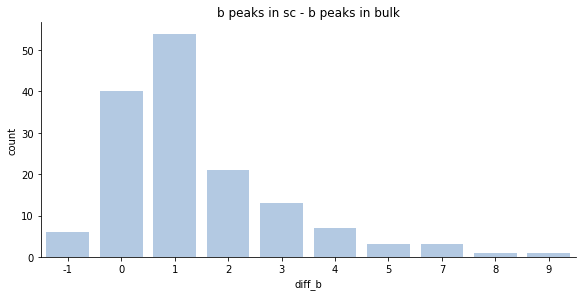

In [71]:
plot = sns.catplot(x="diff_b", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="b peaks in sc - b peaks in bulk")

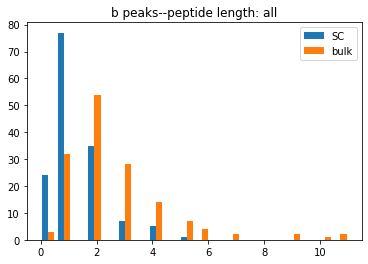

In [72]:
x = small["b_peaks"]
y = large["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: all")

plt.show()

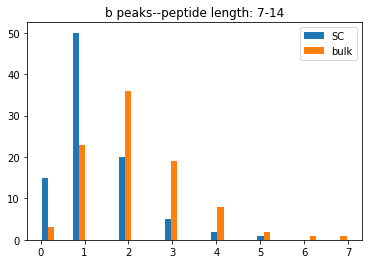

In [73]:
x = small_7to14["b_peaks"]
y = large_7to14["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 7-14")
plt.show()

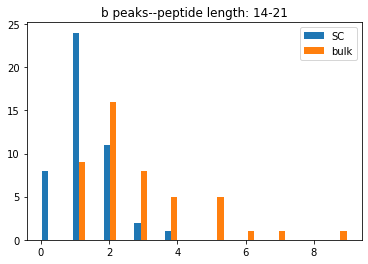

In [74]:
x = small_14to21["b_peaks"]
y = large_14to21["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 14-21")
plt.show()

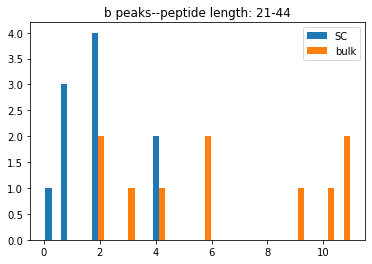

In [75]:
x = small_21to44["b_peaks"]
y = large_21to44["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 21-44")
plt.show()

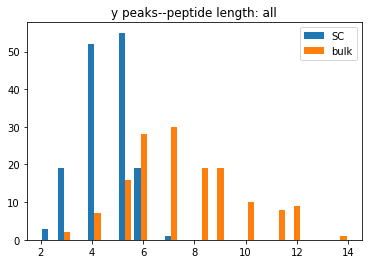

In [76]:
x = small["y_peaks"]
y = large["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: all")
plt.show()

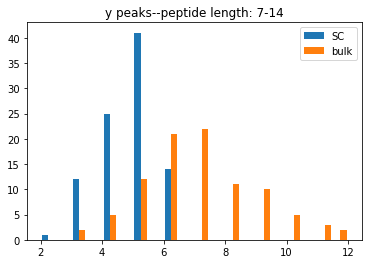

In [77]:
x = small_7to14["y_peaks"]
y = large_7to14["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 7-14")
plt.show()

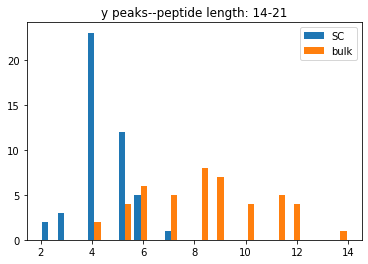

In [78]:
x = small_14to21["y_peaks"]
y = large_14to21["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 14-21")
plt.show()

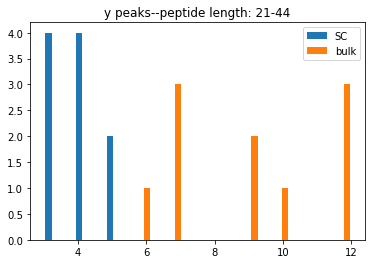

In [79]:
x = small_21to44["y_peaks"]
y = large_21to44["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 21-44")
plt.show()

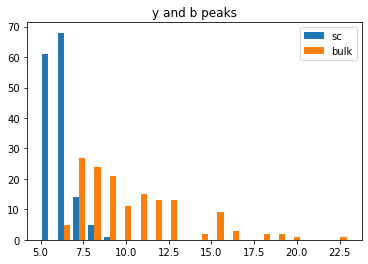

In [80]:
x = small["Matched Ion Counts"]
y = large["Matched Ion Counts"]
plt.hist([x, y], bins=20)
plt.legend(['sc', 'bulk'])
plt.title("y and b peaks")
plt.show()
